In [9]:
import os
import numpy as np
import hdf5storage
import cv2
import matlab
import matlab.engine
from PnP_restoration.utils.utils_restoration import single2uint,crop_center, matlab_style_gauss2D, imread_uint, imsave
from scipy import ndimage
from PIL import Image

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def norm_proj(x):
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    return x

def imsave(img, img_path):
    if img.ndim == 3:
        img = img[:, :, [2, 1, 0]]
    cv2.imwrite(img_path, img)
    
def numpy_degradation(x, k, sf=3):
    ''' blur + downsampling
    Args:
        x: HxWxC image, [0, 1]/[0, 255]
        k: hxw, double, positive
        sf: down-scale factor
    Return:
        downsampled LR image
    '''
    x = ndimage.filters.convolve(x, np.expand_dims(k, axis=2), mode='wrap')
    # x = filters.correlate(x, np.expand_dims(np.flip(k), axis=2))
    st = 0
    return x[st::sf, st::sf, ...]


In [10]:
kernel_path = os.path.join('PnP_restoration/kernels', 'Levin09.mat')
kernels = hdf5storage.loadmat(kernel_path)['kernels']
name = 'butterfly'
k_index = 9
Sf = 1
img_type = 'RGB'
noise_level = 2**0.5 #2**0.5
if k_index == 8 and Sf==1: # Uniform blur
    k = (1/81)*np.ones((9,9))
elif k_index == 9 and Sf==1:  # Gaussian blur
    k = matlab_style_gauss2D(shape=(25,25),sigma=1.6)
elif Sf > 1:  # Gaussian blur
    k = matlab_style_gauss2D(shape=(7,7),sigma=1.6)
else: # Motion blur
    k = kernels[0, k_index]

if img_type == 'RGB':
    input_im_uint = imread_uint('test_images/'+name+'.tif',n_channels=3)
#     input_im_uint = imread_uint('datasets/set12/05.png', n_channels=3)
else:
    input_im_uint = imread_uint('test_images/'+name+'.tif',n_channels=1)
#     input_im_uint = imread_uint('datasets/set12/05.png', n_channels=1)
input_im = np.float32(input_im_uint / 255)
            # Degrade image
if Sf>1:#super-resolution
    blur_im = numpy_degradation(input_im, k, sf=Sf)
else:# debluring
    blur_im = ndimage.filters.convolve(input_im, np.expand_dims(k, axis=2), mode='wrap')
np.random.seed(seed=0)
noise = np.random.normal(0, noise_level / 255., blur_im.shape)
blur_im += noise
init_im = blur_im

/tmp/ipykernel_16069/3216909393.py:28: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  blur_im = ndimage.filters.convolve(input_im, np.expand_dims(k, axis=2), mode='wrap')


/tmp/ipykernel_16069/2741746063.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlt.style.use('seaborn-darkgrid')


(256, 256, 3) (256, 256, 3)


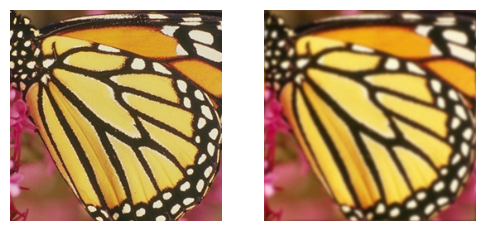

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mlt
mlt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,16))
if img_type == 'RGB':
    ax[0].imshow(input_im_uint)
    # ax[0].set_title('Input image')
    ax[0].set_axis_off()
    ax[1].imshow(np.uint8(norm_proj(init_im)*255))
    # ax[1].set_title('Dice loss')
    ax[1].set_axis_off()
else:
    ax[0].imshow(input_im,cmap='Greys_r')
    # ax[0].set_title('Input image')
    ax[0].set_axis_off()
    ax[1].imshow(init_im, cmap='Greys_r')
    # ax[1].set_title('Dice loss')
    ax[1].set_axis_off()
print(input_im_uint.shape,init_im.shape)

In [12]:
import torch
import torch.nn as nn
import numpy as np
from PnP_restoration.utils.utils_restoration import rgb2y, psnr, array2tensor, tensor2array
from PnP_restoration.utils import utils_sr
from utils.utils import load_model
from utils.utils import psnr
from utils.config import analyze_parse
import math

def initialize_prox(img, degradation_mode, degradation, sf, device):
#     degradation_mode = degradation
    if degradation_mode == 'deblurring':
        k = degradation
        k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
#         FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox(img, k_tensor, sf)
        FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox2(img, k_tensor, sf)
        return FB, FBC, F2B, FBFy, k_tensor
    elif degradation_mode == 'SR':
        k = degradation
        k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
#         FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox(img,k_tensor, sf)
        FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox2(img, k_tensor, sf)
        return FB, FBC, F2B, FBFy, k_tensor
    elif degradation_mode == 'inpainting':
        M = array2tensor(degradation).double().to(device)
        My = M*img
        return My
    else:
        print('degradation mode not treated')

def calulate_data_term(k_tensor,degradation_mode, sf,y,img):
        '''
        Calculation of the data term value f(y)
        :param y: Point where to evaluate F
        :param img: Degraded image
        :return: f(y)
        '''
#         k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
        if degradation_mode == 'deblurring':
            deg_y = utils_sr.imfilter(y.double(), k_tensor[0].double().flip(1).flip(2).expand(3, -1, -1, -1))
            f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
        elif degradation_mode == 'SR':
            deg_y = utils_sr.imfilter(y.double(), k_tensor[0].double().flip(1).flip(2).expand(3, -1, -1, -1))
            deg_y = deg_y[..., 0::sf, 0::sf]
            f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
#         elif degradation_mode == 'inpainting':
#             deg_y = M * y.double()
#             f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
        else:
            print('degradation not implemented')
        return f
        
def rgb2ycbcr(img, only_y=True):
    '''same as matlab rgb2ycbcr
    only_y: only return Y channel
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    if only_y:
        rlt = np.dot(img, [65.481, 128.553, 24.966]) / 255.0 + 16.0
    else:
        rlt = np.matmul(img, [[65.481, -37.797, 112.0], [128.553, -74.203, -93.786],
                              [24.966, 112.0, -18.214]]) / 255.0 + [16, 128, 128]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


def ycbcr2rgb(img):
    '''same as matlab ycbcr2rgb
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    rlt = np.matmul(img, [[0.00456621, 0.00456621, 0.00456621], [0, -0.00153632, 0.00791071],
                          [0.00625893, -0.00318811, 0]]) * 255.0 + [-222.921, 135.576, -276.836]
    rlt = np.clip(rlt, 0, 255)
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)

def single2uint(img):
    return np.uint8(img*255.)

def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

def tensor2uint2(img):
    img = img.data.squeeze().float().cpu().numpy()
    img = norm_proj(img)
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

def tensor2float(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return img

def tensor2float2(img):
    img = img.data.squeeze().float().cpu().numpy()
    img = norm_proj(img)
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return img
    
def calculate_psnr(img1, img2, border=0):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 /np.sqrt(mse))

def calculate_grad(img, degradation_mode, FB, FBC,FBFy,sf=1):
    if degradation_mode == 'deblurring':
        grad = utils_sr.grad_solution(img.double(), FB, FBC, FBFy, 1)
    if degradation_mode == 'SR' :
        grad = utils_sr.grad_solution(img.double(), FB, FBC, FBFy, sf)
    return grad

def calculate_grad2(img, degradation_mode, FB, FBC,FBFy,sf=1):
    if degradation_mode == 'deblurring':
        grad = utils_sr.grad_solution2(img.double(), FB, FBC, FBFy, 1)
    if degradation_mode == 'SR' :
        grad = utils_sr.grad_solution2(img.double(), FB, FBC, FBFy, sf)
    return grad

def load_model(model_type, sigma):
    path = "Pretrained_models/" + model_type + "_noise" + str(sigma) + ".pth"
    if model_type == "DnCNN":
        from model.models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()
    elif model_type == "SimpleCNN":
        from model.SimpleCNN_models import DnCNN
        model = DnCNN(1, num_of_layers = 4, lip = 0.0, no_bn = True).cuda()
    elif model_type == "RealSN_DnCNN":
        from model.realSN_models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()
    elif model_type == "RealSN_SimpleCNN":
        from model.SimpleCNN_models import DnCNN
        model = DnCNN(1, num_of_layers = 4, lip = 1.0, no_bn = True).cuda()
    else:
        from model.realSN_models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()

    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def RED(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    lambdaa = opt['lambda']
    sigma = opt['sigma']
    input_sigma = opt['input_sigma']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    mu = 2/(1/(input_sigma**2) + lambdaa)
    for i in range(K):
        x = x0
        grad1 =  calculate_grad2(x, degradation_mode, FB, FBC, FBFy, sf=Sf)/sigma
        f_est = x 
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        grad2 =  (x - z)
        v_est = x - mu*(grad1/sigma+lambdaa*grad2)
        w = v_est
        residual[i] = torch.norm(w-x0, p=2)
        x0 = w
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def REDPRO(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    lambdaa = opt['lambda']
    sigma = opt['sigma']
    input_sigma = opt['input_sigma']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    mu0 = 2/(1/(input_sigma**2) + lambdaa)
    for i in range(K):
        x = x0
        mu = 1*(i+1)**(-0.1);##############convergence 3
        grad1 =  calculate_grad2(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
        f_est = x - mu*grad1/sigma
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        v_est = beta*z+(1-beta)*f_est
        w = v_est
        residual[i] = torch.norm(w-x0, p=2)
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
        x0 = w
    return x0, obj_fun, residual.float().cpu().numpy()

def SAM_PRO_v2(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad2(z, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = z - mu*grad/sigma
        w = v_est
        residual[i] = torch.norm(w-x0, p=2)
        x_square = torch.norm(x0, p=2)**2
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
        x0 = w
    return x0, obj_fun, residual.float().cpu().numpy()


def SAM_PRO_v1(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
#     y = x0.clone()
#     print(Sf)
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad2(f_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = f_est - alpha*grad/sigma
        w = (1-mu)*z+mu*v_est
        residual[i] = torch.norm(w-x0, p=2)
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
        x0 = w
    return x0, obj_fun, residual.float().cpu().numpy()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
init_im1 = rgb2ycbcr(norm_proj(init_im))
init_im2 = np.expand_dims(init_im1, axis=2)
img_tensor = array2tensor(init_im2).to(device)
if img_type == 'RGB' and Sf==1:
    degradation_mode = 'deblurring'
    x0 = img_tensor#初值
elif Sf>1:
    degradation_mode = 'SR'
    x0 = cv2.resize(init_im1, (init_im1.shape[1] * Sf, init_im1.shape[0] * Sf),interpolation=cv2.INTER_CUBIC)
    x0 = np.expand_dims(x0, axis=2)
    x0 = utils_sr.shift_pixel(x0, Sf)
#     print(x0.shape)
    x0 = array2tensor(x0).to(device)
else:
    img_tensor = array2tensor(init_im).to(device)
FB, FBC, F2B, FBFy, k_tensor = initialize_prox(img_tensor, degradation_mode, k, Sf, device)
################################################algorithm setting
K = 200
beta = 0.26
alpha = 32
if noise_level<=5.0:
    sigma_f=5
elif 15 >= noise_level>5:
    sigma_f=15
elif 40 >= noise_level> 15:
    sigma_f=25
else:
    print('error')
model_type = 'DnCNN' #'RealSN_DnCNN'|'RealSN_SimpleCNN'
opt={'alpha':5, 'beta':0.01, 'sigma':noise_level**2, 'sigma_f':sigma_f, 'K':200, 'mu_0':100, 'sf': Sf}
opt_RED={'alpha':2.4, 'beta':0.01, 'sigma':noise_level**2, 'sigma_f':sigma_f, 'K':200, 'lambda':0.225,'input_sigma':noise_level**2, 'sf': Sf} #for sigma**2=2, starfish, uniform debluring
opt_REDPRO={'alpha':2.4, 'beta':0.01, 'sigma':noise_level**2, 'sigma_f':sigma_f, 'K':200, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}
opt_r={'alpha':4, 'beta':0.01, 'sigma':noise_level**2, 'sigma_f':sigma_f, 'K':200, 'mu_0':100, 'sf': Sf}
f = load_model(model_type, int(opt['sigma_f']))
with torch.no_grad():
    x1, objfun,r = SAM_PRO_v2(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt)
    x_REDPRO, objfun_REDPRO,r_REDPRO = REDPRO(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_REDPRO)
    x_bigsam, objfun_bigsam,r_bigsam = SAM_PRO_v1(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_r)
x_gt_luma = rgb2ycbcr(input_im_uint)

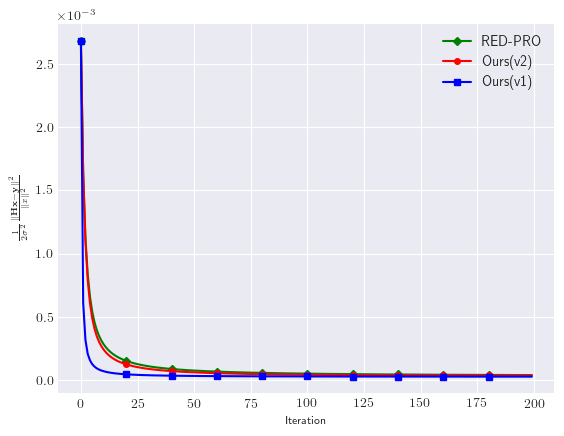

In [14]:
mlt.rcParams['text.usetex'] = True
t =range(200)
plt.plot(t, objfun_REDPRO[:len(t)], color='green', linewidth=1.5, marker='D',markevery=20,markersize=4,label='RED-PRO')
plt.plot(t, objfun[:len(t)], color='red', linewidth=1.5, marker='o', markevery=20, markersize=4, label='Ours(v2)')
plt.plot(t, objfun_bigsam[:len(t)], color='blue', linewidth=1.5, marker='s',markevery=20,markersize=4,label='Ours(v1)')
plt.ylabel(r'$\frac{1}{2\sigma^2}\frac{\|\mathbf{H}\mathbf{x}-\mathbf{y}\|^2}{\|x\|^2}$', fontsize=8)
plt.xlabel('Iteration', fontsize=8)
plt.legend()
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig('convergence_speed.pdf',bbox_inches="tight")
plt.show()